<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2023/06 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Reproducibility of neural networks training with TensorFlow <a name="top"></a>

## [1 $-$ Import Python modules](#1)
## [2 $-$ Reproducibility of pseudo-random generators](#2)
## [3 $-$ A simple example with the MNIST hand-written database](#3)
## [4 $-$ Build the neural network](#4)
## [5 $-$ Reproducibility tests](#5)


<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

## 1 $-$ Import Python modules <a name="1"></a>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

The **keras** module which allows high level manipulation of **tensorflow** objects is integrated in tensorflow2. <br>
The **tf.keras** module documentation to consult for this lab is here: https://www.tensorflow.org/api_docs/python/tf/keras.

In [2]:
import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

Python    : 3.8.13
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.23.1


Incrustation des tracés matplotlib dans le notebook et import de modules utiles :

In [3]:
%matplotlib inline

Specific tools:

In [4]:
from utils.tools import plot_loss_accuracy

# 2 $-$ Reproducibility of pseudo-random generators <a name="2"></a>

## The Reproducibility problem:

The weights of a neural network are initialized by __random values__ : when pseudo-random generators are invoked several times in succession, different random sequence are created at each invocation. For example with `numpy.random.rand`:

In [5]:
import numpy as np
for _ in range(5):
    print(np.random.rand(6))

[0.28721179 0.70299827 0.94749854 0.20506369 0.24516214 0.77461469]
[0.87319164 0.89818532 0.90595453 0.98835233 0.24325214 0.12481963]
[0.63190415 0.31816555 0.44755484 0.21425815 0.977322   0.05768056]
[0.92539785 0.21472509 0.9041037  0.72071601 0.6909041  0.87314986]
[0.29746192 0.05838444 0.59836784 0.67536494 0.67493129 0.53290992]


<h3 style="color:brown">point of interest</h3>

<span style="color:brown">This behavior can be very inappropriate when studying the performance of a trained network as a function of meta-parameters:<br>every time you run the training of the neural network (runing the cell or the notebook) with different values of the meta-parameters, you get a different initial state of the network, leading to a different training network...
</spawn>

[top](#top)

## A way to ensure reproductibility 

### The seed of random generators

The technical solution to get a reproducible random sequence from a (pseudo) random generator is to set the __seed__ of the generator.<br>

The following cells illustrate the mechanism:

In [6]:
for _ in range(5):
    np.random.seed(1234)
    print(np.random.rand(5))

[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]


<h3 style="color:brown">point of interest</h3>

<span style="color:brown">Setting the __seed__ ensure that the random sequence is the same even on other computers (Windows, Mac, Linux...)
</spawn>

Of course if you change the seed you get a different random sequence:

In [7]:
SEED = 2345

In [8]:
for _ in range(5):
    np.random.seed(SEED)
    print(np.random.rand(5))

[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]


In [9]:
np.random.seed(SEED)
np.random.rand(5)

array([0.66064431, 0.41360065, 0.66810256, 0.22994342, 0.80767834])

In [10]:
np.random.rand(5)

array([0.63681846, 0.17219385, 0.26038587, 0.91531999, 0.46281551])

[top](#top)

## 3 $-$ A simple example with the MNIST hand-written database <a name="3"></a>

Load the MNIST database:

In [11]:
(im_train, lab_train), (im_test, lab_test) = keras.datasets.mnist.load_data()

Have a look the shape of the ndarrays:

In [12]:
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


### Visualization of images and labels:

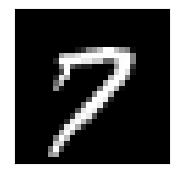

In [13]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[599], cmap='gray')
plt.xticks([]); plt.yticks([]);

Let's check that the MNIST label associated with `im_train[600]` corresponds to what we see on the image:

In [14]:
lab_train[599]

7

In the cell below, we sort the images and display lines of '0', lines of '1'... :

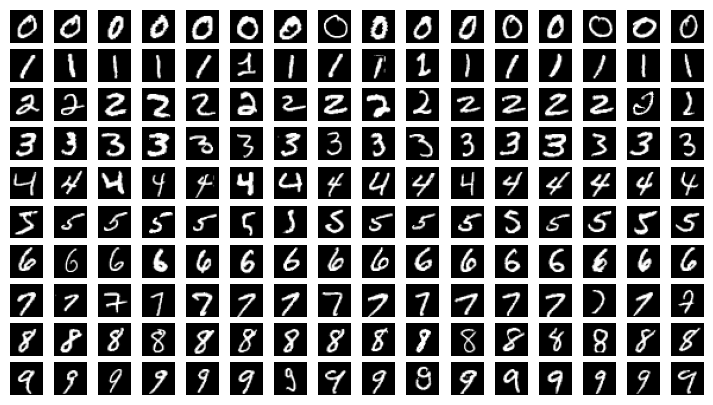

In [15]:
data = []
for i in range(10):
    indexes = np.where(lab_train == i) # indices des labels égaux à i
    i_data = im_train[indexes][:16]    # tableau des images correspondates
    data.append(i_data)

plt.figure(figsize=(9,5))
L, C = len(data), len(data[0])
for row, digits in enumerate(data):
    for col, digit in enumerate(digits):
        plt.subplot(L, C , row*C + col + 1)
        plt.imshow(digit, cmap='gray')
        plt.xticks([]); plt.yticks([])
        plt.box(False)
plt.show()        

### MNIST data pre-processing

To avoid "hard banging" the _number of training and test images_ as well as _the size of the images_, we retrieve these parameters:
- with the `shape` attribute of the `im_train` and `im_test` arrays
- with the `size` attribute of the first training image for example

In [16]:
nb_im_train = im_train.shape[0]    # nb of training images
nb_im_test  = im_test.shape[0]     # nb of test images
nb_pixel    = im_train[0].size     # nb of alements (pixels) of the first training image 
nb_classe   = len(set(lab_train))  # nb of classe to be identified (the 10 digits from 0 to 9)

# Check:
print(f"{nb_im_train} training images and {nb_im_test} test images")
print(f"{nb_pixel} pixels in every image")

60000 training images and 10000 test images
784 pixels in every image


### Transformation of input matrices into normalized vectors:

Now let's define the `x_train` and `x_test` arrays containing the matrices of the `im_train` and `im_test` arrays *flattened* as normalized vectors (values between 0 and 1):

In [17]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_test  = im_test.reshape(nb_im_test, nb_pixel)/im_test.max()

print(f"{x_train.shape=}, {x_test.shape=}")
print(f"{x_train.min()=}, {x_train.max()=}")
print(f"{x_test.min()=}, {x_test.max()=}")

x_train.shape=(60000, 784), x_test.shape=(10000, 784)
x_train.min()=0.0, x_train.max()=1.0
x_test.min()=0.0, x_test.max()=1.0


### *one-hot* encoding of labels:

We use the `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the new arrays `y_train` et `y_test` holding the *hot-one* codings of `lab_train` and `lab_test` :

In [18]:
from tensorflow.keras.utils import to_categorical

# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


[top](#top)

## 4 $-$ Construction of the neural network<a name="4"></a>

 To get very short computation times we build a very simple dense network to classify MNIST images : of course, this is not the "state of the art" : convolutive NN, transformers have much more impressive scores, but we just want want short training computation time:
We build a naive **dense network**, with:
- an **input layer** of 784 values (the pixels of the MNIST 28 $\times$ 28 images put in the form of a vector of 784 normalized `float` numbers),
- a **hidden layer** of 784 neurons using the `relu` activation function,
- an **output layer** of 10 neurons, for the classification of the 10 digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems .

<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/archiNetwork.png" alt="archiNetwork.png" style="width: 900px;"><br>
     [image credit: JLC]

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set tensorflow seed:
tf.random.set_seed(1234)

# The 5 lines to build the dense network:
model = Sequential()
model.add(Input(shape=(nb_pixel,), name='input'))
model.add(Dense(nb_pixel, activation='relu', name='c1'))
model.add(Dense(nb_classe, activation='softmax', name='c2'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

### Saving the state of the NN

We can save the __initial random state__ of the weights of the untrained network with the `save_weights` method of the `Sequential` class:

In [20]:
import os

# check if the 'weights' directory exists, otherwise create it:
if not os.path.isdir("weights"): os.mkdir("weights")

#saving the initial values of the NN weights:
key = 'initialNN_w10'
model.save_weights('weights/'+key)

# display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights")]
files.sort()
for f in files: print(f)

weights\checkpoint
weights\initialNN.data-00000-of-00001
weights\initialNN.index
weights\initialNN_w10.data-00000-of-00001
weights\initialNN_w10.index


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">$\leadsto$ This can be useful to reset the network to its initial state before running new trainings
</spawn>

### Saving the full structure and the weights of the NN

The `save` method of the `Sequential` class allows to save in files **the full structure and the weights** of the NN:

In [21]:
import os

# check if the 'weights' directory exists, otherwise create it:
if not os.path.isdir("models"): os.mkdir("models")

#saving the initial values of the NN weights:
key = 'initialNN_w10'
model.save('models/'+key) 

# display the created files:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/initialNN_w10\assets
models\initialNN_w10


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">We can re-create later from scratch the entire network (initial or trained state) with the __tf.keras.models.load_model__ function.
</spawn>

### Training the network

For the purposes of the discussion we will use a low value of the parameter n_epoch (5)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
    
def build_NN(seed=None):
    if seed is not None: tf.random.set_seed(seed)    
    # The 5 lines to build the dense network:
    model = Sequential()
    model.add(Input(shape=(nb_pixel,), name='input'))
    model.add(Dense(nb_pixel, activation='relu', name='c1'))
    model.add(Dense(nb_classe, activation='softmax', name='c2'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    
    return model

[top](#top)

## 5 $-$ The reproducibility of the training <a name="5"></a>

Perfect reproducibility of a neural network training may be difficult to achieve with tensorflow...

### Reproducibility on one `epoch`

To highlight the question of reproducibility we begin by training the network with only __one epoch__:`n_epoch=1`.<br>
In the cell bellow, the initial state of the network is reloaded at each turn of the loop **before running the training with `fit`**:<br>

If we don't set the seed, the training is not reproducible:

In [33]:
for _ in range(5):
    
    # Build a new network at each time
    model = build_NN()

    hist = model.fit(x_train, y_train, epochs=1, batch_size=128, validation_data=(x_test, y_test))

469/469 [==============================] - 4s 9ms/step - loss: 0.2489 - accuracy: 0.9281 - val_loss: 0.1242 - val_accuracy: 0.9626


Is the seed is set, the training is reproductible:

In [34]:
for _ in range(5):
    
    # Build a new network at each time
    model = build_NN(1234)

    hist = model.fit(x_train, y_train, epochs=1, batch_size=128, validation_data=(x_test, y_test))

469/469 [==============================] - 6s 13ms/step - loss: 0.2479 - accuracy: 0.9293 - val_loss: 0.1263 - val_accuracy: 0.9636


# Autres ressources intéressantes... des vidéos :

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### The seed of TF random generator

To apply this mechanism to tensorflow, we can use the `set_seed` function (see page [tf.random.set_seed](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)) :
**`tf.random.set_seed(SEED)`**

In [9]:
print(tf.random.uniform([4]))  #
print(tf.random.uniform([4]))  #

tf.Tensor([0.86926746 0.88675964 0.20335901 0.19382417], shape=(4,), dtype=float32)
tf.Tensor([0.25484586 0.26162863 0.32027018 0.56117284], shape=(4,), dtype=float32)


In [10]:
print(tf.random.uniform([4]))  #
print(tf.random.uniform([4]))  #

tf.Tensor([0.27649856 0.69480824 0.4428755  0.19380927], shape=(4,), dtype=float32)
tf.Tensor([0.28420365 0.5790794  0.63630104 0.3320843 ], shape=(4,), dtype=float32)


In [11]:
tf.random.set_seed(1234)
print(tf.random.uniform([4]))  #
print(tf.random.uniform([4]))  #

tf.Tensor([0.5380393  0.36461866 0.5816301  0.24382842], shape=(4,), dtype=float32)
tf.Tensor([0.3253647  0.1387006  0.64804935 0.30401838], shape=(4,), dtype=float32)


In [12]:
tf.random.set_seed(1234)
print(tf.random.uniform([4]))  #
print(tf.random.uniform([4]))  #

tf.Tensor([0.5380393  0.36461866 0.5816301  0.24382842], shape=(4,), dtype=float32)
tf.Tensor([0.3253647  0.1387006  0.64804935 0.30401838], shape=(4,), dtype=float32)
